# Driver code

In [2]:
%matplotlib widget
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Raw_Data.bulk_and_open_system_model import get_plots_geometries, get_plots_3d
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import auxiliary_funcs as aux
from tqdm import tqdm, notebook
import time
import pickle
from IPython.utils import io
from IPython.display import display
import os
import scipy as sp
import matplotlib.cm as cm


plt.rcParams["text.usetex"] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
start_time = time.time()

## Getting geometries plots

In [87]:
# Constants
flat_band_on_off = 0
N_band = 2
N = 1
alfa = 0.6
Nx = 24
Ny = Nx
X, Y = np.meshgrid(np.arange(0, Nx, 1), np.arange(0, Ny, 1))
hopping_range = 4
dk = 0.1
kx_vec = np.arange(-np.pi, np.pi, dk)

# Notebook features control room
Here you can toggle model trainig, saving, loading etc.
Options explanation:
* Plot EDA option - Show all the plots exploring the dataframe we created, as well as plots showing data counts and structure
* Plot fig optin - Generate figures from the tutorial
* Plot Models option - Plot stats of the trained/loaded models

In [4]:
save = False
plot = True
plot_models = True
plot_EDA = False
plot_fig = True
train = False
load = True
load_datasets = True
hparam_search = False
if train:
    load = False
if not plot:
    plot_models = False
    plot_EDA = False
    plot_fig = False

**Figure 2.1**

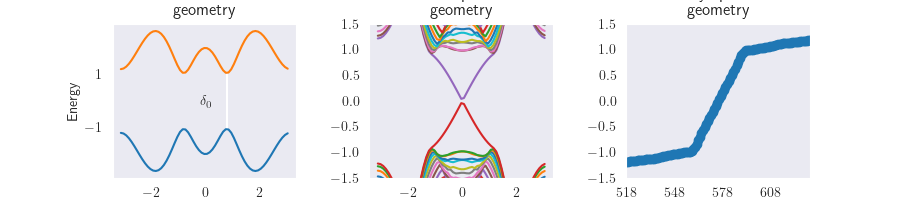

In [88]:
# mu and line_len can be modified to get figures from the tutorial
mu = -2
line_len = [0.8, -1.1, 0, 2.1]
parameters = np.array([N, mu, alfa, flat_band_on_off])
# Uncomment below for beautiful plot, but not scientifically accuarate :)
if plot_fig:
    # with plt.xkcd():
    get_plots_geometries(Nx, Ny, hopping_range, N, flat_band_on_off, mu, alfa, line_len, parameters, dk, N_band)


































**Figure 2.2**

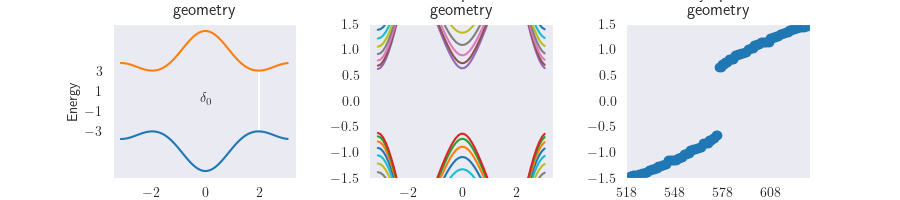

In [89]:
# mu and line_len can be modified to get figures from the tutorial
mu = 3
line_len = [2, -3, 0, 6]
parameters = np.array([N, mu, alfa, flat_band_on_off])
# Uncomment below for beautiful plot, but not scientifically accuarate :)
if plot_fig:
    # with plt.xkcd():
    get_plots_geometries(Nx, Ny, hopping_range, N, flat_band_on_off, mu, alfa, line_len, parameters, dk, N_band)

**Plot 3**

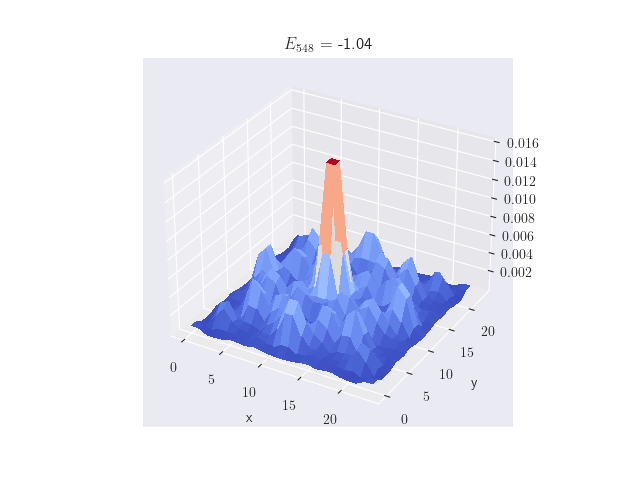

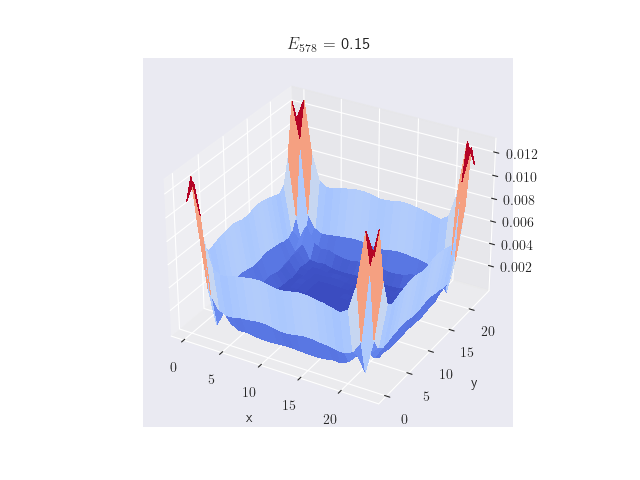

In [90]:
mu = -2
line_len = [0.8, -1.1, 0, 2.1]
parameters = np.array([N, mu, alfa, flat_band_on_off])
if plot_fig:
    get_plots_3d(Nx, Ny, hopping_range, parameters, X, Y)
plt.close("all")

## Getting data from Pandas and EDA

Reading data saved prevously

In [7]:
output = pd.read_pickle("Raw_Data/pandas_data_set_Shiba_data.pkl")

In [8]:
output.shape

(85570, 13)

We print first 20 rows of the DataFrame to get a sense of what can we encounter there

In [9]:
if plot_EDA:
    display(output.head(20))

We can see that even though the bulk chern marker groups have even counts, their dispersions are not even. Group with bulk chern marker 2 is much more dispersed than the other three. We may have slight suspisions that it might be the hardest to spot for the NN later on.

In [10]:
if plot_EDA:
    plt.figure()
    plt.title("Bulk chern marker count")
    sns.countplot(x=output["Chern_bulk"])
    plt.show()

In [11]:
if plot_EDA:
    plt.figure()
    plt.title("Disordered chern marker vs bulk chern")
    sns.histplot(output, x="Chern_marker_disorder", hue="Chern_bulk", palette=plt.cm.viridis)
    plt.show()


We set *train* and *test* data sets by train-test-split from sklearn's model selection module with shuffle option enabled
*test* dataset size will be 20% of the raw dataset. Train dataset will be further processed for fine-tuning the model, while the test dataset will be left as is.

In [12]:
test_proc = 0.1
X_train, X_test = train_test_split(output, test_size=test_proc, shuffle=True, stratify=output["Chern_bulk"])
print("Shape of the raw data is ", output.shape)
print("Shape of the train data is ", X_train.shape, ", and of the test data ", X_test.shape)

Shape of the raw data is  (85570, 13)
Shape of the train data is  (77013, 13) , and of the test data  (8557, 13)


Now we would like to make our train data linearly separable for the NN, so we transfrom them the way to eliminate the overlaps seen on the plot above

Here we can see that after first step of normalization (setting $V_0 < 1$) we already went down from $68456$ samples to $\sim 32600$ samples (exact number varies due to shuffling done during split)

In [13]:
X_train = X_train.loc[X_train["v_sample"] < 1]
X_train.reset_index(drop=True, inplace=True)
X_train.shape

(36715, 13)

In [14]:
if plot_EDA:
    display(X_train.head(5))

Now let's apply second normalization condition, that is $|C - C_m| < 0.5$

In [15]:
X_train["|C-C_m|"] = X_train["Chern_bulk"] - X_train["Chern_marker_disorder"]

In [16]:
if plot_EDA:
    display(X_train.head(30))

In [17]:
X_train = X_train.loc[X_train["|C-C_m|"] < 0.5]
X_train.reset_index(drop=True, inplace=True)
X_train.shape

(32559, 14)

In [18]:
if plot_EDA:
    plt.figure()
    plt.title("Disordered chern marker vs bulk chern - Training Dataset Cleaned")
    sns.histplot(X_train, x="Chern_marker_disorder", hue="Chern_bulk", palette=plt.cm.viridis)
    plt.show()

In [19]:
if plot_EDA:
    # Uncomment below for beautiful plot, but not scientifically accuarate :)
    # with plt.xkcd():
    plt.figure()
    plt.title("Bulk chern marker count - Training Dataset")
    sns.countplot(x=X_train["Chern_bulk"])
    plt.show()

In [20]:
if plot_EDA:
    plt.figure()
    plt.title("Bulk chern marker count - Test Dataset")
    sns.countplot(x=X_test["Chern_bulk"])
    plt.show()

After all the steps of data cleaning we are good to split it into *training dataset* and the *validation dataset* we will use to train our CNN. But first we need to drop all the unnecessary columns in both Training and Test dataset, as our CNN will be learning to recognise images (24x24 matrices) of LDOS, with *one-hot-encoded* Bulk Chern Numbers $|C_n|$ as labels.

**NOTE**
    If possible rerun the raw data genration for lattice 34x34, and 10 000 samples. To be seen. I.E. How big of a system would you need to get Chern 4, or 5

In [97]:
def get_disorder_slice(X_test_df, disorder=0.0, step=0.1):
    X_test_no_disorder = X_test_df.copy()
    if disorder == 0.0:
        X_test_no_disorder = X_test_no_disorder[X_test_no_disorder["v_sample"] == disorder]
    else:
        X_test_no_disorder = X_test_no_disorder[X_test_no_disorder["v_sample"].between(disorder - step, disorder)]
    X_test_no_disorder.reset_index(drop=True, inplace=True)
    X_test_no_disorder.loc[:, ["LDOS","Chern_bulk"]]
    X_test_no_disorder, Y_test_no_disorder = X_test_no_disorder["LDOS"], X_test_no_disorder["Chern_bulk"]
    for i in range(X_test_no_disorder.shape[0]):
        mean = np.mean(X_test_no_disorder.iloc[i])
        maximum = np.max(X_test_no_disorder.iloc[i])
        std = np.std(X_test_no_disorder.iloc[i])
        if mean > 0:
            X_test_no_disorder.iloc[i] = X_test_no_disorder.iloc[i] / std
    X_test_no_disorder = X_test_no_disorder.to_list()
    X_test_no_disorder = tf.convert_to_tensor(X_test_no_disorder)
    X_test_no_disorder = tf.reshape(X_test_no_disorder, [-1, 24,24, 1])

    Y_test_no_disorder = tf.cast(Y_test_no_disorder, "int32")
    depth = 4
    Y_test_no_disorder = tf.one_hot(Y_test_no_disorder, depth)
    return X_test_no_disorder, Y_test_no_disorder

In [109]:
def get_slice_c_marker(X, c_marker=0, disorder=0, step=0.1):
    cm_samples = X.loc[X["Chern_bulk"] == c_marker]
    cm_samples.reset_index(drop=True, inplace=True)
    X_out, Y_out = get_disorder_slice(cm_samples, disorder=disorder, step=step)
    return X_out, Y_out

---

In [23]:
X_train_various_disorders = X_train.copy()
disorder_tab = np.arange(0.0, 2.0, 0.1)

In [26]:
# X_train_no_disorder, Y_train_no_disorder = get_disorder_slice(X_train_no_disorder, disorder=0)
X_train_disorder_slices = {}
Y_train_disorder_slices = {}
for disorder in disorder_tab:
    X_train_disorder_slices["v={:.1f}".format(disorder)], Y_train_disorder_slices["v={:.1f}".format(disorder)] = get_disorder_slice(X_train_various_disorders, disorder=disorder)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-27 05:36:44.168455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 05:36:44.168624: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [27]:
X_train_disorder_slices.keys()

dict_keys(['v=0.0', 'v=0.1', 'v=0.2', 'v=0.3', 'v=0.4', 'v=0.5', 'v=0.6', 'v=0.7', 'v=0.8', 'v=0.9', 'v=1.0', 'v=1.1', 'v=1.2', 'v=1.3', 'v=1.4', 'v=1.5', 'v=1.6', 'v=1.7', 'v=1.8', 'v=1.9'])

In [412]:
Y_train_disorder_slices.keys()

dict_keys(['v=0.0', 'v=0.1', 'v=0.2', 'v=0.3', 'v=0.4', 'v=0.5', 'v=0.6', 'v=0.7', 'v=0.8', 'v=0.9', 'v=1.0', 'v=1.1', 'v=1.2', 'v=1.3', 'v=1.4', 'v=1.5', 'v=1.6', 'v=1.7', 'v=1.8', 'v=1.9'])

---

In [31]:
X_test_various_disorders = X_test.copy()

In [33]:
X_test_disorder_slices = {}
Y_test_disorder_slices = {}
for disorder in disorder_tab:
    X_test_disorder_slices["v={:.1f}".format(disorder)], Y_test_disorder_slices["v={:.1f}".format(disorder)] = get_disorder_slice(X_test_various_disorders, disorder=disorder)

In [68]:
X_test_disorder_slices.keys()

dict_keys(['v=0.0', 'v=0.1', 'v=0.2', 'v=0.3', 'v=0.4', 'v=0.5', 'v=0.6', 'v=0.7', 'v=0.8', 'v=0.9', 'v=1.0', 'v=1.1', 'v=1.2', 'v=1.3', 'v=1.4', 'v=1.5', 'v=1.6', 'v=1.7', 'v=1.8', 'v=1.9'])

In [405]:
Y_test_disorder_slices.keys()

dict_keys(['v=0.0', 'v=0.1', 'v=0.2', 'v=0.3', 'v=0.4', 'v=0.5', 'v=0.6', 'v=0.7', 'v=0.8', 'v=0.9', 'v=1.0', 'v=1.1', 'v=1.2', 'v=1.3', 'v=1.4', 'v=1.5', 'v=1.6', 'v=1.7', 'v=1.8', 'v=1.9'])

---

In [99]:
X = X_test_various_disorders

In [110]:
X_test_disorders_by_chern = {}
Y_test_disorders_by_chern = {}
cm_tab = [0.0, 1.0, 2.0, 3.0]
for disorder in disorder_tab:
    for chern in cm_tab:
        if chern == 0.0:
            X_test_disorders_by_chern["v={:.1f}".format(disorder)] = {}
            Y_test_disorders_by_chern["v={:.1f}".format(disorder)] = {}
        X_test_disorders_by_chern["v={:.1f}".format(disorder)]["|C|={:.1f}".format(chern)], Y_test_disorders_by_chern["v={:.1f}".format(disorder)]["|C|={:.1f}".format(chern)] = get_slice_c_marker(X_test_various_disorders, disorder=disorder, c_marker=chern)

---

In [70]:
X_train = X_train.loc[:, ["LDOS","Chern_bulk"]]
X_test = X_test.loc[:, ["LDOS","Chern_bulk"]]

In [71]:
if plot_EDA:
    display(X_train.head(12))

When we print out the first element, we see that it has desired length, as $24\cdot24 = 576$

In [72]:
X_train.iloc[0]["LDOS"].shape

(576,)

We can interpret these matrices as images, like the ones pictured below

**TODO** : Add second row with V_0 = 0. To this plot add disroder >1. Then $C_M$ =0 can give bulk states. Look for this, and maybe extract the data for reproducibility of figures

In [73]:
LDOS_V_0 = output[output["v_sample"] == 0].loc[:, ["LDOS","Chern_bulk"]]
LDOS_V_geq_1 = output[output["v_sample"] >= 1].loc[:, ["LDOS","Chern_bulk"]]
LDOS_V_0.reset_index(drop=True, inplace=True)
LDOS_V_geq_1.reset_index(drop=True, inplace=True)

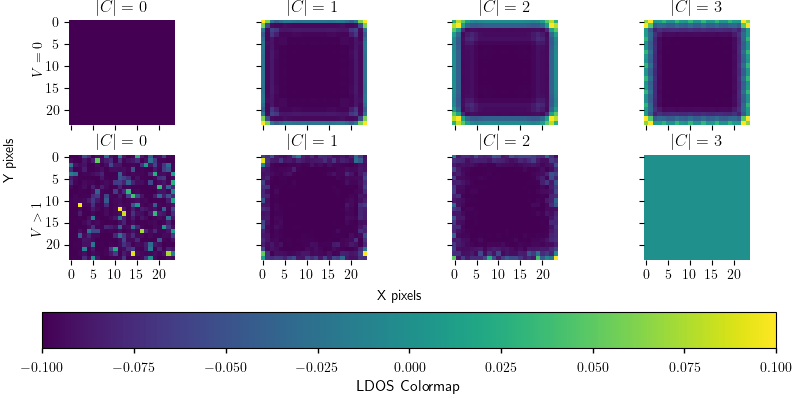

In [74]:
aux.get_figure_repr_1_comparison_disorder(LDOS_V_0, LDOS_V_geq_1, num=35)

In [75]:
if plot_EDA:
    aux.get_figure_repr_1(LDOS_V_0)

We can now clean the test data from the unnecesary columns, and split it in data and labels

In [76]:
X_test, Y_test = X_test["LDOS"], X_test["Chern_bulk"]
X_train, X_val, Y_train, Y_val = train_test_split(X_train["LDOS"], X_train["Chern_bulk"], test_size=0.2, shuffle=True, stratify=X_train["Chern_bulk"])

Now we can split the training data into real training dataset and validation dataset, along with splitting the labels

We can check dimensionality just in case

In [77]:
print("Shapes of X_train data: {}, Y_train labels: {}".format(X_train.shape, Y_train.shape))
print("Shapes of X_val data: {}, Y_val labels: {}".format(X_val.shape, Y_val.shape))
print("Shapes of X_test data: {}, Y_test labels: {}".format(X_test.shape, Y_test.shape))

Shapes of X_train data: (26010,), Y_train labels: (26010,)
Shapes of X_val data: (6503,), Y_val labels: (6503,)
Shapes of X_test data: (8557,), Y_test labels: (8557,)


Now let's normalize the data

In [78]:
if plot_EDA:
    display(X_train)

LDOS Normalization

In [79]:
for i in range(X_train.shape[0]):
    mean = np.mean(X_train.iloc[i])
    maximum = np.max(X_train.iloc[i])
    std = np.std(X_train.iloc[i])
    if mean > 0:
        X_train.iloc[i] = X_train.iloc[i] / std

In [80]:
for i in range(X_val.shape[0]):
    mean = np.mean(X_val.iloc[i])
    maximum = np.max(X_val.iloc[i])
    std = np.std(X_val.iloc[i])
    if mean > 0:
        X_val.iloc[i] = X_val.iloc[i] / std

In [81]:
for i in range(X_test.shape[0]):
    mean = np.mean(X_test.iloc[i])
    maximum = np.max(X_test.iloc[i])
    std = np.std(X_test.iloc[i])
    if mean > 0:
        X_test.iloc[i] = X_test.iloc[i] / std

In [82]:
X_train = X_train.to_list()
X_val = X_val.to_list()
X_test = X_test.to_list()

In [83]:
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
X_test = tf.convert_to_tensor(X_test)

In [84]:
X_train = tf.reshape(X_train, [-1, 24,24, 1])
X_val = tf.reshape(X_val, [-1, 24,24, 1])
X_test = tf.reshape(X_test, [-1, 24,24, 1])

In [85]:
Y_train = tf.cast(Y_train, "int32")
Y_val = tf.cast(Y_val, "int32")
Y_test = tf.cast(Y_test, "int32")

In [86]:
depth = 4

Y_train = tf.one_hot(Y_train, depth)
Y_val = tf.one_hot(Y_val, depth)
Y_test = tf.one_hot(Y_test, depth)

And **NOW** we can get into creating and training a CNN model

In [87]:
if plot_EDA:
    display(Y_train)

## Loading pre-processed Datasets if you don't want to process them by yourself

In [479]:
if load_datasets:
    # Loading datasets

    # # Training Dataset
    wrpath = "Datasets/X_train.pickle"
    with open(wrpath, "rb") as f:
        X_train = pickle.load(f)

    wrpath = "Datasets/Y_train.pickle"
    with open(wrpath, "rb") as f:
        Y_train = pickle.load(f)

    # # Validation Dataset
    wrpath = "Datasets/X_val.pickle"
    with open(wrpath, "rb") as f:
        X_val = pickle.load(f)

    wrpath = "Datasets/Y_val.pickle"
    with open(wrpath, "rb") as f:
        Y_val = pickle.load(f)

    # # Test Dataset
    wrpath = "Datasets/X_test.pickle"
    with open(wrpath, "rb") as f:
        X_test = pickle.load(f)

    wrpath = "Datasets/Y_test.pickle"
    with open(wrpath, "rb") as f:
        Y_test = pickle.load(f)

# Unsupervised approach

## PCA

**Todo: Unsupervised on cleaned data (chern clean column) as comparison**

Let's try exploring our data with PCA, to see if there are any visible clusters

In [88]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import plotly.express as px

Applying the PCA and visualization

In [281]:
if load:
    wrpath = "Unsupervised/PCA_before_AE.pickle"
    with open(wrpath, "rb") as f:
        principal_df = pickle.load(f)
    df = pd.DataFrame(X_train.numpy().reshape(-1, 576))

In [90]:
if train:
    df = pd.DataFrame(X_train_no_disorder.numpy().reshape(-1, 576))
    principal_df = PCA().fit_transform(df)
    colnames = [f"principal component {name}" for name in range(1, principal_df.shape[1]+1)]
    principal_df = pd.DataFrame(data=principal_df, columns = colnames)
    principal_df["class"] = Y_train_no_disorder.numpy().argmax(axis=1)

In [282]:
if plot_models:
    fig_PCA = px.scatter_3d(principal_df, x='principal component 1', y='principal component 2', z='principal component 3', opacity=0.7, color="class", color_discrete_map="Set1")
    fig_PCA.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    display(fig_PCA)

In [ ]:
if save:
    wrpath = "Unsupervised/PCA_before_AE.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(principal_df, f)

As we can see above, the data can't be clearly separated with PCA, apart from $|C_m| = 0$. The reason for this can be seen in the plot below. In order to separate more than $90%$ of the data we would need to consider 90 principal components.

In [ ]:
if plot_models:
    pca = PCA().fit(df.loc[:, :])
    y_PCA = np.cumsum(pca.explained_variance_ratio_)
    fig = plt.figure()
    plt.plot(np.linspace(0, y_PCA.shape[0], y_PCA.shape[0]), y_PCA, label="x dimensions needed to separate y \% of data")
    plt.hlines(0.9, 0, y_PCA.shape[0], colors="r", label="90\% separability threshold")
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.legend()
    plt.gcf().set_size_inches(7, 5)

**Todo - retrain autoencoder with dimensions resulting from this plot**
Result - No better results

## tSNE

Applying the PCA and visualization

In [284]:
df_TSNE = pd.DataFrame(X_train.numpy().reshape(-1, 576))

In [285]:
if load:
    wrpath = "Unsupervised/tSNE_before_AE.pickle"
    with open(wrpath, "rb") as f:
        TSNE_df = pickle.load(f)

In [ ]:
if train:
    TSNE_df = TSNE(learning_rate=100, perplexity=40, n_components=3, init='pca', n_jobs=-1).fit_transform(df_TSNE)

In [286]:
if plot_models:
    if not load:
        TSNE_df = pd.DataFrame(data=TSNE_df, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
        TSNE_df["class"] = Y_train.numpy().argmax(axis=1)
    fig_TSNE = px.scatter_3d(TSNE_df, x='principal component 1', y='principal component 2', z='principal component 3', opacity=0.7, color="class", color_discrete_map="Set1")
    fig_TSNE.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    display(fig_TSNE)

In [ ]:
if save:
    wrpath = "Unsupervised/tSNE_before_AE.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(TSNE_df, f)

## Autoencoder

*Code adapted from [TensorFlow.org tutorial](https://www.tensorflow.org/tutorials/generative/autoencoder)*

In [287]:
from keras import layers, losses

In [288]:
AE_train = tf.reshape(X_train, [-1, 24,24])
AE_val = tf.reshape(X_val, [-1, 24,24])
AE_test = tf.reshape(X_test, [-1, 24,24])

In [290]:
if load:
    wrpath = "Models/Autoencoder.pickle"
    with open(wrpath, "rb") as f:
        autoencoder = pickle.load(f)

EOFError: Ran out of input

In [297]:
latent_dim = 24

class Autoencoder(keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(576, activation='sigmoid'),
            layers.Reshape((24, 24))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [298]:
train = True
if train:
    AE_fit = autoencoder.fit(AE_train, AE_train,
                epochs=100,
                shuffle=True,
                validation_data=(AE_val, AE_val))

Epoch 1/100


2022-04-25 22:17:00.130274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


813/813 [==============================] - ETA: 0s - loss: 0.5016

2022-04-25 22:17:06.914831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


813/813 [==============================] - 8s 8ms/step - loss: 0.5016 - val_loss: 0.4650
Epoch 2/100
813/813 [==============================] - 6s 7ms/step - loss: 0.4627 - val_loss: 0.4617
Epoch 3/100
813/813 [==============================] - 7s 8ms/step - loss: 0.4610 - val_loss: 0.4609
Epoch 4/100
813/813 [==============================] - 10s 12ms/step - loss: 0.4601 - val_loss: 0.4603
Epoch 5/100
813/813 [==============================] - 8s 9ms/step - loss: 0.4596 - val_loss: 0.4600
Epoch 6/100
813/813 [==============================] - 7s 8ms/step - loss: 0.4592 - val_loss: 0.4598
Epoch 7/100
813/813 [==============================] - 6s 8ms/step - loss: 0.4588 - val_loss: 0.4595
Epoch 8/100
813/813 [==============================] - 7s 8ms/step - loss: 0.4585 - val_loss: 0.4595
Epoch 9/100
813/813 [==============================] - 7s 8ms/step - loss: 0.4583 - val_loss: 0.4593
Epoch 10/100
813/813 [==============================] - 9s 11ms/step - loss: 0.4581 - val_loss: 0.459

KeyboardInterrupt: 

**Do it other way: look at the ***bottleneck***, not the reconstructed images**

In [ ]:
encoded_imgs = autoencoder.encoder(AE_test).numpy()
# decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
decoded_imgs = encoded_imgs

In [ ]:
if save:
    wrpath = "Models/Autoencoder.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(autoencoder, f)

Let's see if passing the data through an autoencoder helped with clusterisation

### PCA

In [292]:
if load:
    wrpath = "Unsupervised/PCA_after_AE.pickle"
    with open(wrpath, "rb") as f:
        principal_df_AE = pickle.load(f)

In [ ]:
if train:
    principal_df_AE = PCA().fit_transform(decoded_imgs)
    colnames = [f"principal component {name}" for name in range(1, principal_df_AE.shape[1]+1)]
    principal_df_AE = pd.DataFrame(data=principal_df_AE, columns = colnames)
    principal_df_AE["class"] = Y_test.numpy().argmax(axis=1)

In [293]:
if plot_models:
    fig_PCA_AE = px.scatter_3d(principal_df_AE, x='principal component 1', y='principal component 2', z='principal component 3', opacity=0.7, color="class", color_discrete_map="Set1")
    fig_PCA_AE.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    display(fig_PCA_AE)

In [ ]:
if save:
    wrpath = "Unsupervised/PCA_after_AE.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(principal_df_AE, f)

### tSNE

In [ ]:
if train:
    TSNE_df_AE = TSNE(learning_rate=100, perplexity=30, n_components=3, init='pca', n_jobs=-1).fit_transform(decoded_imgs)
    TSNE_df_AE = pd.DataFrame(data=TSNE_df_AE, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    TSNE_df_AE["class"] = Y_test.numpy().argmax(axis=1)

In [ ]:
if plot_models:
    fig_TSNE_AE = px.scatter_3d(TSNE_df_AE, x='principal component 1', y='principal component 2', z='principal component 3', opacity=0.7, color="class", color_discrete_map="Set1")
    fig_TSNE_AE.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    display(fig_TSNE_AE)

In [ ]:
if save:
    wrpath = "Unsupervised/tSNE_after_AE.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(TSNE_df_AE, f)

# Supervised Approach

## Setting up a CNN model

In [117]:
def getModelA(
    nFilters,
    nNeurons,
    dropout_rate,
    inputShape,
    outputWidth,
    ):
    
    inputs = tf.keras.Input(shape=inputShape)
    x = inputs
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(nNeurons//2, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy']
    )
    return model

In [118]:
def getModelB(
    nFilters,
    kernel_size,
    pool_size,
    dropout_rate,
    inputShape,
    outputWidth,
    ):
    
    inputs = tf.keras.Input(shape=inputShape)
    x = inputs
    x = tf.keras.layers.Conv2D(nFilters, kernel_size=kernel_size, strides=(1,1), activation=tf.nn.relu, padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=(2,2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy']
    )
    return model

In [119]:
def getModelC(
    nFilters,
    kernel_size,
    pool_size,
    nHiddenLayers,
    dropout_rate,
    inputShape,
    outputWidth,
    ):
    
    inputs = tf.keras.Input(shape=inputShape)
    x = inputs
    for iHidden in range(nHiddenLayers):
        x = tf.keras.layers.Conv2D(filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=2)(x)
        x = tf.keras.layers.Conv2D(filters=nFilters//2, kernel_size=kernel_size, activation=tf.nn.relu)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy']
    )
    return model

# Training CNN models

In [179]:
verb=0
dropout_rate = 0.5
l2_lambda = 0.001
epochs = 100
batch_size = 256
# nFilters = 64
nFilters = 100
kernel_size = (3,3)
pool_size = (2,2)
nNeurons = 256
nHiddenLayers = 1
inputShape = (24, 24, 1)
outputWidth = 4
noRuns = 5
labels = ["$|C_m| = 0$", "$|C_m| = 1$", "$|C_m| = 2$", "$|C_m| = 3$"]
labels_no_tex = ["|C_m| = 0", "|C_m| = 1", "|C_m| = 2", "|C_m| = 3"]

## Loading pre-trained models if you're here only for the plotting this time

In [120]:
if load:
    # loading best models
    with open("Models/best_model_A.pickle", "rb") as f:
        model_A = pickle.load(f)
    with open("Models/best_model_B.pickle", "rb") as f:
        model_B = pickle.load(f)
    with open("Models/best_model_C.pickle", "rb") as f:
        model_C = pickle.load(f)

    # Saving history files for further plotting
    with open("History/train_hist_10_runs_model_A.pickle", "rb") as f:
        model_A_hist_tab = pickle.load(f)
    with open("History/train_hist_10_runs_model_B.pickle", "rb") as f:
        model_B_hist_tab = pickle.load(f)
    with open("History/train_hist_10_runs_model_C.pickle", "rb") as f:
        model_C_hist_tab = pickle.load(f)

    # Saving fully trained models array for further plotting
    with open("Models/train_10_runs_model_A.pickle", "rb") as f:
        model_A_tab = pickle.load(f)
    with open("Models/train_10_runs_model_B.pickle", "rb") as f:
        model_B_tab = pickle.load(f)
    with open("Models/train_10_runs_model_C.pickle", "rb") as f:
        model_C_tab = pickle.load(f)

## Model A

In [ ]:
%%time


filepath = "Checkpoints/Model_A.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_accuracy",
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    mode="max",
)

if train:

    model_A_tab = []
    model_A_hist_tab = []

    for run in tqdm(range(noRuns), desc="Loading..."):
        model_A = getModelA(nFilters, nNeurons, dropout_rate, inputShape, outputWidth)

        if verb == 0:
            with io.capture_output() as captured:
                model_A_fit = model_A.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=verb, use_multiprocessing=True, callbacks=[checkpoint])
        else:
            model_A_fit = model_A.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=verb, use_multiprocessing=True, callbacks=[checkpoint])

        model_A_tab.append(model_A)
        model_A_hist_tab.append(model_A_fit)
    model_A.load_weights(filepath)

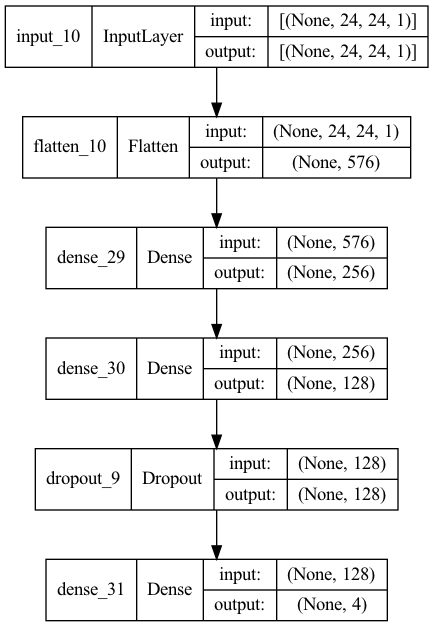

In [300]:
# model_A.summary()
if plot_models:
    display(tf.keras.utils.plot_model(model_A, 'ML_model_A.png', show_shapes=True))

2022-04-25 22:25:44.399833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.56      1.00      0.72      2141
           1       0.97      0.58      0.73      2138
           2       0.64      0.67      0.65      2157
           3       0.89      0.49      0.63      2121

    accuracy                           0.69      8557
   macro avg       0.76      0.68      0.68      8557
weighted avg       0.76      0.69      0.68      8557



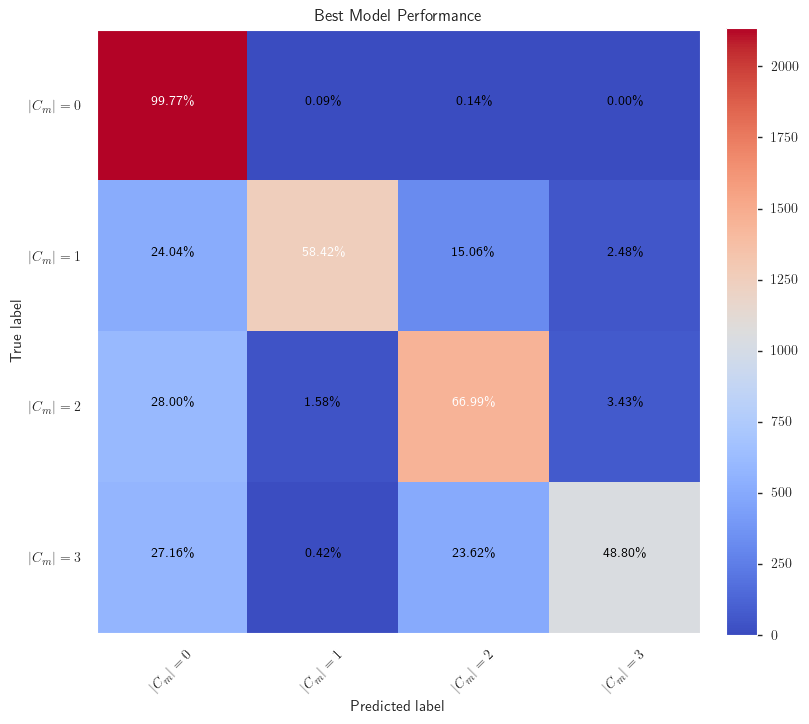

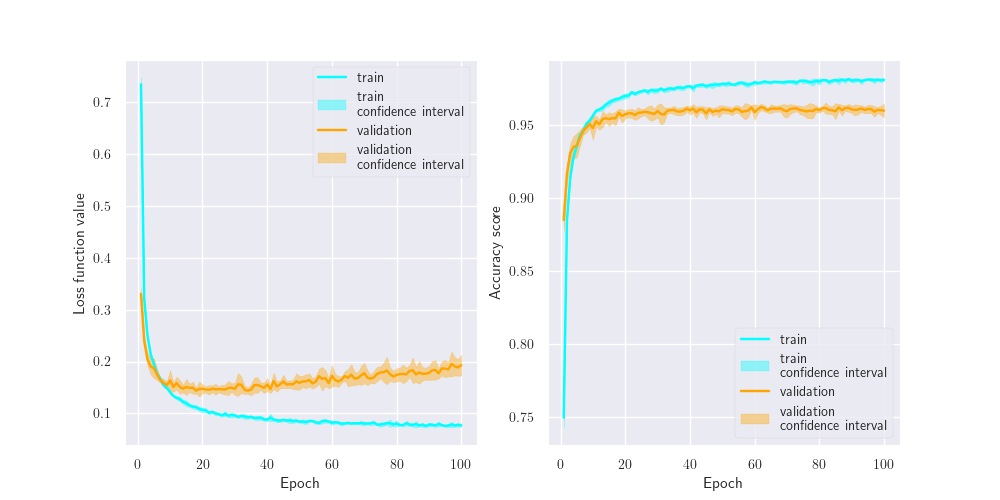

In [301]:
if plot_models:
    # with plt.xkcd():
    cm = aux.printScores(model_A, X_test,  Y_test)
    display(aux.plot_confusion_matrix(cm, class_names=labels, title="Best Model Performance"))
    # aux.plotHistScores(model_A, X_test, Y_test, title="Best model precision\nCorrect Classification Percentage", tick_labels=labels)
    aux.plotTrainingHistory_avg(model_A_hist_tab, alpha=0.4)
    # aux.plotHistScores_tab(model_A_tab, X_test, Y_test, tick_labels=labels)
    # ROC_1 = aux.roc_auc(model_A, X_test,  Y_test, title="ROC characteristic of best model")

**TODO** colormap the confusion matrix as procent of true class representatives (row-wise)**

## Model B

In [ ]:
%%time

filepath = "Checkpoints/Model_B.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_accuracy",
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    mode="max",
)
if train:
    model_B_tab = []
    model_B_hist_tab = []

    for run in tqdm(range(noRuns), desc="Loading..."):
        model_B = getModelB(
            nFilters,
            kernel_size,
            pool_size,
            dropout_rate,
            inputShape,
            outputWidth,
        )

        if verb == 0:
            with io.capture_output() as captured:
                model_B_fit = model_B.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=verb, use_multiprocessing=True, callbacks=[checkpoint])
        else:
            model_B_fit = model_B.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=verb, use_multiprocessing=True, callbacks=[checkpoint])

        model_B_tab.append(model_B)
        model_B_hist_tab.append(model_B_fit)
    #   Loading best model
    model_B.load_weights(filepath)

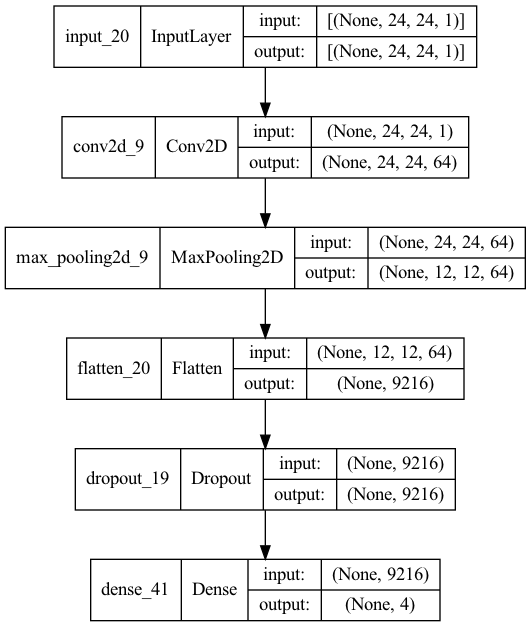

In [302]:
# model_B.summary()
if plot_models:
    display(tf.keras.utils.plot_model(model_B, 'ML_model_B.png', show_shapes=True))

2022-04-25 22:27:08.396757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.63      0.99      0.77      2141
           1       0.97      0.67      0.79      2138
           2       0.70      0.82      0.76      2157
           3       0.96      0.53      0.68      2121

    accuracy                           0.75      8557
   macro avg       0.81      0.75      0.75      8557
weighted avg       0.81      0.75      0.75      8557



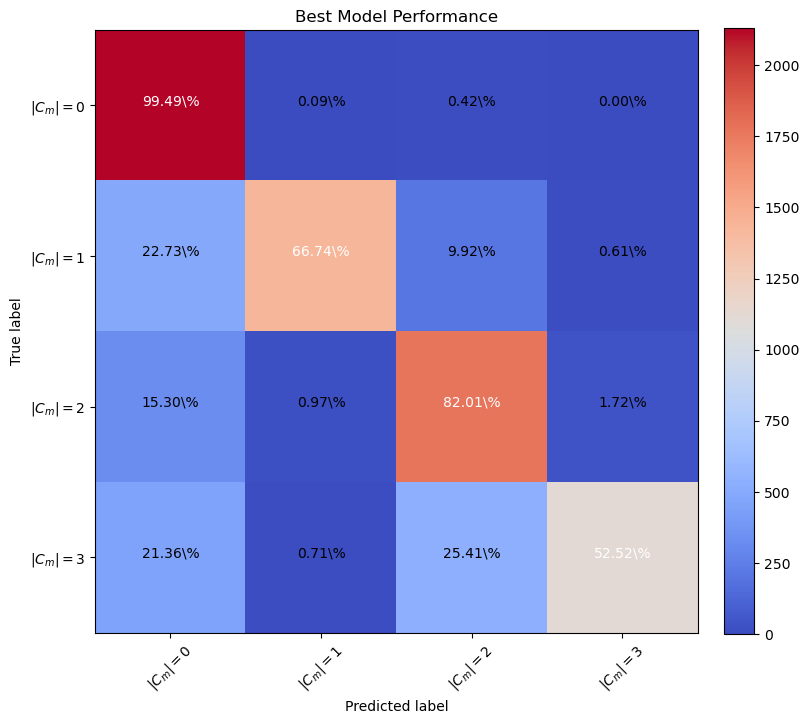

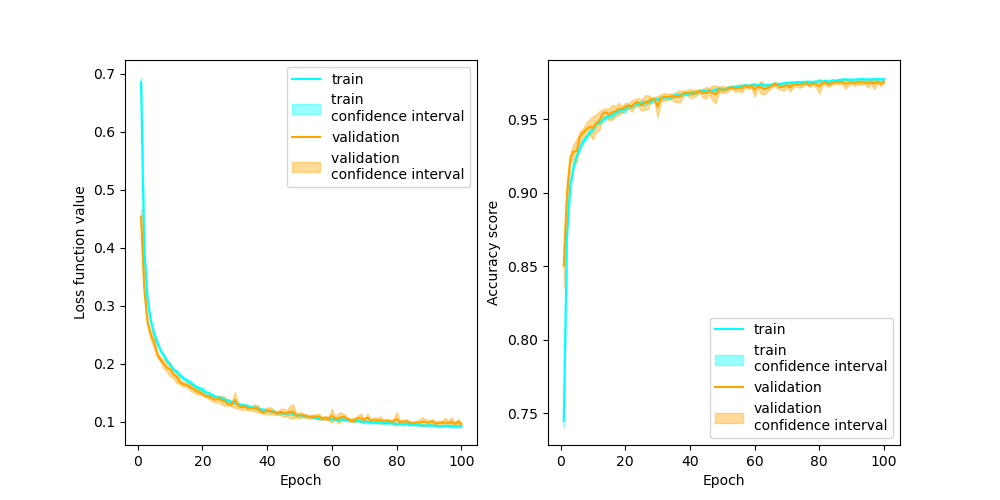

In [303]:
if plot_models:
    plt.rcdefaults()
    # with plt.xkcd():
    cm = aux.printScores(model_B, X_test,  Y_test)
    display(aux.plot_confusion_matrix(cm, class_names=labels, title="Best Model Performance"))
    # aux.plotHistScores(model_B, X_test, Y_test, title="Best model performance\nCorrect Classification Percentage", tick_labels=labels)
    aux.plotTrainingHistory_avg(model_B_hist_tab, alpha=0.4)
    # aux.plotHistScores_tab(model_B_tab, X_test, Y_test, tick_labels=labels)
    # ROC_1 = aux.roc_auc(model_B, X_test,  Y_test, title="ROC characteristic of best model")

## Model C

In [ ]:
%%time

filepath = "Checkpoints/Model_C.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_accuracy",
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    mode="max",
)

if train:
    model_C_tab = []
    model_C_hist_tab = []

    for run in tqdm(range(noRuns), desc="Loading..."):
        model_C = getModelC(nFilters,
                            kernel_size,
                            pool_size,
                            nHiddenLayers,
                            dropout_rate,
                            inputShape,
                            outputWidth,
                            )
        if verb == 0:
            with io.capture_output() as captured:
                model_C_fit = model_C.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=verb, use_multiprocessing=True, callbacks=[checkpoint])
        else:
            model_C_fit = model_C.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=verb, use_multiprocessing=True, callbacks=[checkpoint])

        model_C_tab.append(model_C)
        model_C_hist_tab.append(model_C_fit)
    model_C.load_weights(filepath)

In [ ]:
# model_C.summary()
if plot_models:
    display(tf.keras.utils.plot_model(model_C, 'ML_model_C.png', show_shapes=True))

2022-04-25 22:27:30.654813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.75      0.98      0.85      2141
           1       0.96      0.68      0.80      2138
           2       0.63      0.90      0.74      2157
           3       0.97      0.53      0.69      2121

    accuracy                           0.78      8557
   macro avg       0.83      0.77      0.77      8557
weighted avg       0.83      0.78      0.77      8557



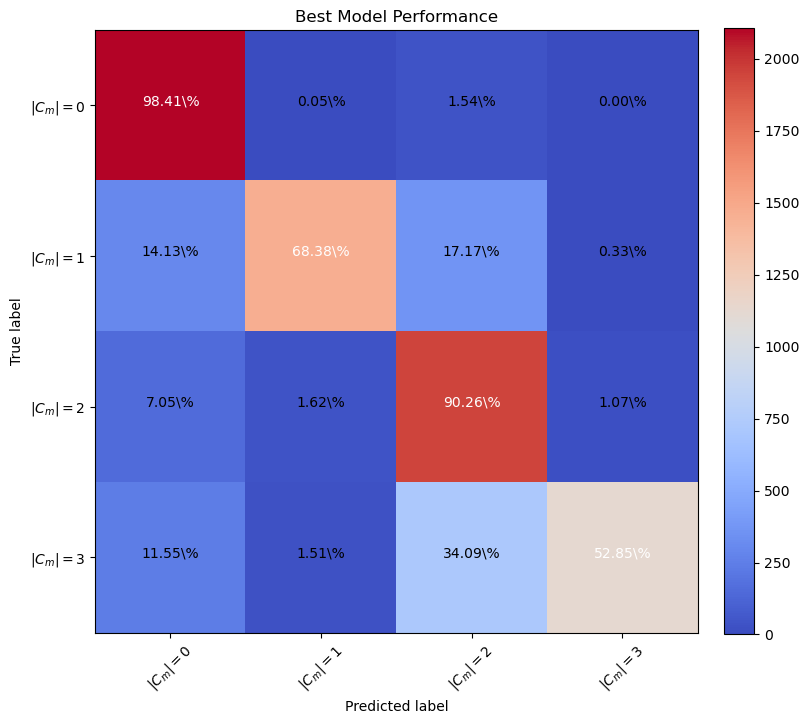

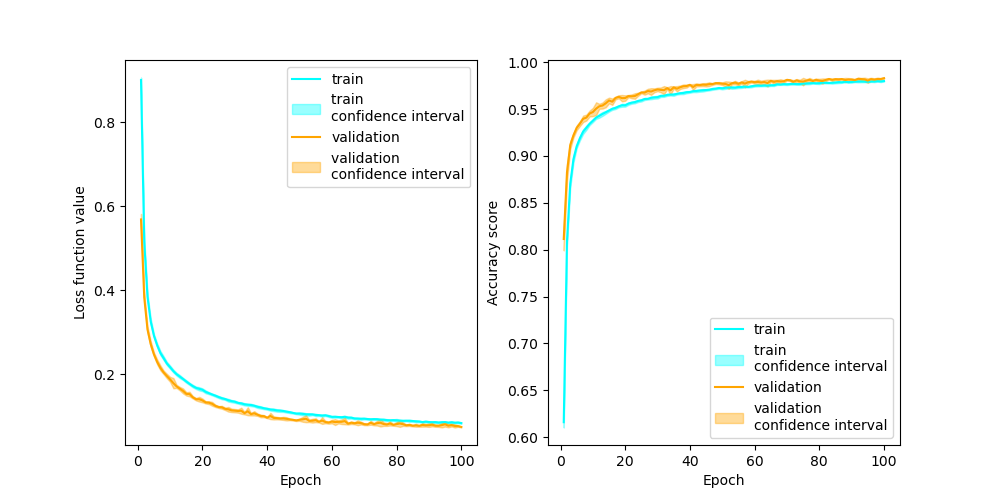

In [304]:
# with plt.xkcd():
if plot_models:
    cm = aux.printScores(model_C, X_test,  Y_test)
    display(aux.plot_confusion_matrix(cm, class_names=labels, title="Best Model Performance"))
    # aux.plotHistScores(model_C, X_test, Y_test, title="Best model performance\nCorrect Classification Percentage", tick_labels=labels)
    aux.plotTrainingHistory_avg(model_C_hist_tab, alpha=0.4)
    # aux.plotHistScores_tab(model_C_tab, X_test, Y_test, tick_labels=labels)
    # ROC_1 = aux.roc_auc(model_C, X_test,  Y_test, title="ROC characteristic of best model", labels=labels)

# Saving models and Datasets

In [ ]:
if save:

    # Saving best models

    # # Model A
    wrpath = "Models/best_model_A.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_A, f)

    # # Model B
    wrpath = "Models/best_model_B.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_B, f)

    # # Model C
    wrpath = "Models/best_model_C.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_C, f)

    # Saving history files for further plotting

    # # Model A
    wrpath = "History/train_hist_10_runs_model_A.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_A_hist_tab, f)

    # # Model B
    wrpath = "History/train_hist_10_runs_model_B.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_B_hist_tab, f)

    # # Model C
    wrpath = "History/train_hist_10_runs_model_C.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_C_hist_tab, f)

    # Saving fully trained models array for further plotting

    # # Model A
    wrpath = "Models/train_10_runs_model_A.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_A_tab, f)

    # # Model B
    wrpath = "Models/train_10_runs_model_B.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_B_tab, f)

    # # Model C
    wrpath = "Models/train_10_runs_model_C.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_C_tab, f)


    # Saving datasets

    # # Training Dataset
    wrpath = "Datasets/X_train.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(X_train, f)

    wrpath = "Datasets/Y_train.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(Y_train, f)

    # # Validation Dataset
    wrpath = "Datasets/X_val.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(X_val, f)

    wrpath = "Datasets/Y_val.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(Y_val, f)

    # # Test Dataset
    wrpath = "Datasets/X_test.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(X_test, f)

    wrpath = "Datasets/Y_test.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(Y_test, f)

---

In [159]:
Y_test_disorders_by_chern["v=0.0"]["|C|=3.0"]

<tf.Tensor: shape=(100, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],


In [169]:
def get_avg_acc(X, Y, models_tab):
    model_names_tab = ["Model A", "Model B", "Model C"]
    model_A_tab, model_B_tab, model_C_tab = models_tab
    acc_v_disorder_tab = {}

    for model_name in notebook.tqdm(model_names_tab, desc="No. Of model run"):
        acc_v_disorder_tab["{}".format(model_name)] = {}

        if model_name == "Model A":
            model_tab = model_A_tab
        if model_name == "Model B":
            model_tab = model_B_tab
        if model_name == "Model C":
            model_tab = model_C_tab
        for num, model_acc_v_disorder in notebook.tqdm(enumerate(model_tab), desc="No. of model in model_tab"):
            for key in X.keys():
                if num == 0:
                    acc_v_disorder_tab["{}".format(model_name)][key] = {}
                for chern in X[key].keys():
                    if num == 0:
                        acc_v_disorder_tab["{}".format(model_name)][key][chern] = []
                    _, acc = aux.printScores(model_acc_v_disorder, X[key][chern],  Y[key][chern], get_acc=True, supress=True)
                    acc_v_disorder_tab["{}".format(model_name)][key][chern].append(acc)

    for model_name in model_names_tab:
        for key in X.keys():
            for chern in X[key].keys():
                acc_v_disorder_tab[model_name][key][chern] = np.average(acc_v_disorder_tab[model_name][key][chern], axis=0), np.std(acc_v_disorder_tab[model_name][key][chern], axis=0)
    return acc_v_disorder_tab

In [232]:
import warnings
from itertools import cycle
from matplotlib import ticker

In [170]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    acc_v_disorder_tab = get_avg_acc(X_test_disorders_by_chern, Y_test_disorders_by_chern, [model_A_tab, model_B_tab, model_C_tab])

No. Of model run:   0%|          | 0/3 [00:00<?, ?it/s]

No. of model in model_tab: 0it [00:00, ?it/s]

No. of model in model_tab: 0it [00:00, ?it/s]

No. of model in model_tab: 0it [00:00, ?it/s]

In [174]:
acc_v_disorder_tab["Model A"].keys()

dict_keys(['v=0.0', 'v=0.1', 'v=0.2', 'v=0.3', 'v=0.4', 'v=0.5', 'v=0.6', 'v=0.7', 'v=0.8', 'v=0.9', 'v=1.0', 'v=1.1', 'v=1.2', 'v=1.3', 'v=1.4', 'v=1.5', 'v=1.6', 'v=1.7', 'v=1.8', 'v=1.9'])

In [282]:
sns.set()

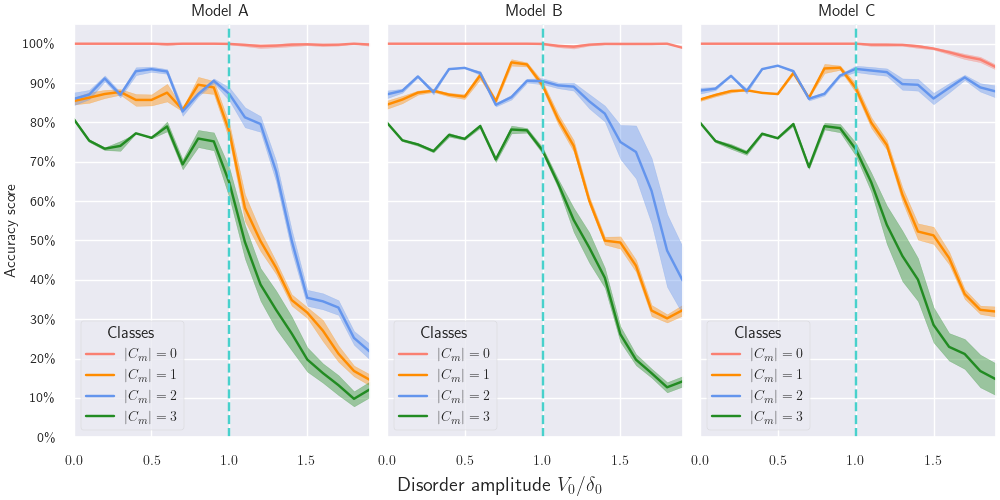

In [305]:
plt.close("all")
fig, axes = plt.subplots(1, 3, sharey="row", figsize=(10, 5), constrained_layout=True)
plt.style.use("seaborn-notebook")
class_names = labels
save_title = "Figures/Acc_scores_fig.pdf"
alpha = 0.4

for pos, model in enumerate(["Model A", "Model B", "Model C"]):
    cm_tab = {}
    cm_std_tab = {}
    dis_pos = []
    for num, key in enumerate(acc_v_disorder_tab[model].keys()):
        dis_pos.append(float(key[2:]))
        for key_chern in acc_v_disorder_tab[model][key].keys():
            if num == 0:
                cm_tab[key_chern] = []
                cm_std_tab[key_chern] = []
            avg, std = acc_v_disorder_tab[model][key][key_chern]
            cm_tab[key_chern].append(avg)
            cm_std_tab[key_chern].append(std)

    colors = cycle(["Salmon", "darkorange", "cornflowerblue", "forestgreen"])
    for key_chern, label_acc, color in zip(acc_v_disorder_tab[model][key].keys(), labels, colors):
        axes[pos].plot(dis_pos, cm_tab[key_chern], color=color, label=label_acc)
        axes[pos].fill_between(
            dis_pos,
            np.add(cm_tab[key_chern], cm_std_tab[key_chern]),
            np.subtract(cm_tab[key_chern], cm_std_tab[key_chern]),
            color=color,
            alpha=alpha,
            label="_confidence interval",
        )
    axes[pos].set_title(model)
    axes[pos].set_ylabel("Accuracy score")
    axes[pos].set_xlim(0, 1.9)
    axes[pos].set_ylim(0,1.05)
    axes[pos].legend(loc=0, title="Classes", frameon=True)
    axes[pos].axvline(1.0, ls="--", color="mediumturquoise")
    formatter = ticker.PercentFormatter(xmax=1.0)
    axes[pos].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    axes[pos].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    axes[pos].yaxis.set_major_formatter(formatter)
    axes[pos].yaxis.set_minor_formatter(ticker.NullFormatter())

fig.supxlabel("Disorder amplitude $V_0/\delta_0$")
for ax in axes.flat:
    ax.label_outer()

if save_title is not None:
    plt.savefig(save_title)

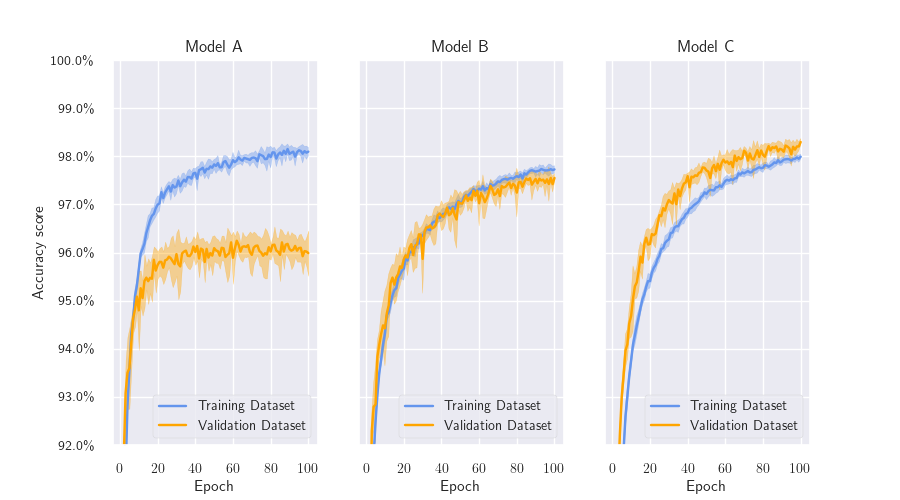

In [292]:
aux.plotTrainingHistory_avg_model_tab([model_A_hist_tab,model_B_hist_tab,model_C_hist_tab], alpha=0.4, figshape=(9,5), title_tab=["Model A", "Model B", "Model C"], save_title="Figures/Acc_scores_hist.pdf")

In [249]:
def get_avg_cm(X_test_disorder_slices, models_tab):
    model_names_tab = ["Model A", "Model B", "Model C"]
    model_A_tab, model_B_tab, model_C_tab = models_tab
    cm_v_disorder_tab = {}

    for model_name in model_names_tab:
        cm_v_disorder_tab["{}".format(model_name)] = {}

        if model_name == "Model A":
            model_tab = model_A_tab
        if model_name == "Model B":
            model_tab = model_B_tab
        if model_name == "Model C":
            model_tab = model_C_tab
        for num, model_acc_v_disorder in enumerate(model_tab):
            for key in X_test_disorder_slices.keys():
                if num == 0:
                    cm_v_disorder_tab["{}".format(model_name)][key] = []

                cm, _ = aux.printScores(model_acc_v_disorder, X_test_disorder_slices[key],  Y_test_disorder_slices[key], get_acc=True, supress=True)
                cm_v_disorder_tab["{}".format(model_name)][key].append(cm)

    for model_name in model_names_tab:
        for key in X_test_disorder_slices.keys():
            cm_v_disorder_tab[model_name][key] = np.average(cm_v_disorder_tab[model_name][key], axis=0)
    return cm_v_disorder_tab

In [121]:
cm_v_disorder_tab = get_avg_cm(X_test_disorder_slices, [model_A_tab, model_B_tab, model_C_tab])

2022-04-27 06:14:34.740792: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-27 06:14:34.781195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-27 06:14:36.942472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-27 06:14:38.259358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-27 06:14:39.612005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-27 06:14:40.797538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-27 06:14:42.080394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112

/var/folders/4f/nc8733x97cnbfw1jfx_t9mfm0000gn/T/ipykernel_71541/3064975568.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(pcm, ax=[axs], location="right", label="Accuracy $\%$", fraction=0.046, pad=0.04)


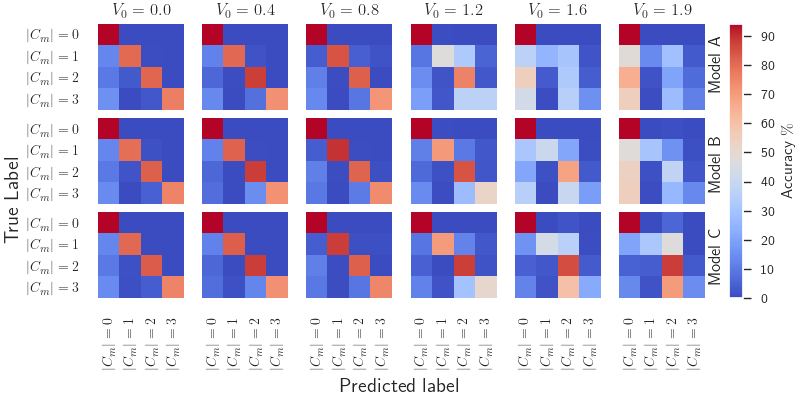

In [309]:
fig, axs = plt.subplots(3, 6, sharey="row", figsize=(8, 4), constrained_layout=True)
plt.style.use("seaborn-notebook")
class_names = labels
save_title = "Figures/Confusion_Matrix.pdf"

model_names_tab = ["Model A", "Model B", "Model C"]
disorders = ["v=0.0", "v=0.4", "v=0.8", "v=1.2", "v=1.6", "v=1.9"]
disorders_labels = ["$V_0=0.0$", "$V_0=0.4$", "$V_0=0.8$", "$V_0=1.2$", "$V_0=1.6$", "$V_0=1.9$"]

cmap = "coolwarm"

for row, model_name in zip(range(3), model_names_tab):
    for idx, disorder, label in zip(range(6), disorders, disorders_labels):
        cm = cm_v_disorder_tab[model_name][disorder]
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]*100
        pcm = axs[row, idx].imshow(cm, interpolation="nearest", cmap=cmap)
        axs[row, idx].set_title(f"{label}")

tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names, rotation=45)
# plt.yticks(tick_marks, class_names)

fig.text(0.885, 0.84, "Model A", va="center", rotation="vertical")
fig.text(0.885, 0.59, "Model B", va="center", rotation="vertical")
fig.text(0.885, 0.36, "Model C", va="center", rotation="vertical")

cb = fig.colorbar(pcm, ax=[axs], location="right", label="Accuracy $\%$", fraction=0.046, pad=0.04)
cb.set_ticks(range(0,100,10))
cb.set_ticklabels(range(0,100,10))

fig.supxlabel("Predicted label")
fig.supylabel("True Label")

for ax in axs.flat:
    ax.set(frame_on=False, xticks=(tick_marks), yticks=(tick_marks))
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names)
    ax.grid(visible=False)

for ax in axs.flat:
    if not ax.get_subplotspec().is_first_row():
        ax.set_title(None)
    ax.label_outer()

if save_title is not None:
    plt.savefig(save_title)

___

# Modifying architecture for CAM

In [305]:
def getModelB_CAM(
    nFilters,
    kernel_size,
    pool_size,
    dropout_rate,
    inputShape,
    outputWidth,
    ):

    inputs = tf.keras.Input(shape=inputShape)
    x = inputs
    x = tf.keras.layers.Conv2D(nFilters//4, kernel_size=kernel_size, strides=(1,1), activation=tf.nn.relu, padding="same")(x)
    x = tf.keras.layers.Conv2D(nFilters//2, kernel_size=kernel_size, strides=(1,1), activation=tf.nn.relu, padding="same")(x)
    # x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=(2,2))(x)
    x = tf.keras.layers.Conv2D(nFilters, kernel_size=kernel_size, strides=(1,1), activation=tf.nn.relu, padding="same", kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=0.1, epsilon=0.1)
    model.compile(
        loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy']
    )
    return model

In [ ]:
noRuns_CAM = 5
verb = 1
epochs = 50
l2 = 0.01
kernel_size = 80

In [ ]:
%%time

filepath = "Checkpoints/Model_B_CAM.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_accuracy",
    verbose=verb,
    save_weights_only=True,
    save_best_only=True,
    mode="max",
)

model_B_CAM_tab = []
model_B_CAM_hist_tab = []

for run in tqdm(range(noRuns_CAM), desc="Loading..."):
    model_B_CAM = getModelB_CAM(
        nFilters,
        kernel_size,
        pool_size,
        dropout_rate,
        inputShape,
        outputWidth,
    )

    if verb == 0:
        with io.capture_output() as captured:
            model_B_CAM_fit = model_B_CAM.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=verb, use_multiprocessing=True, callbacks=[checkpoint])
    else:
        model_B_CAM_fit = model_B_CAM.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=verb, use_multiprocessing=True, callbacks=[checkpoint])

    model_B_CAM_tab.append(model_B_CAM)
    model_B_CAM_hist_tab.append(model_B_CAM_fit)
#   Loading best model
model_B_CAM.load_weights(filepath)

---

Here we verified if different parameters of model didn't work better. But the default ones seem to be the best.

In [ ]:
from tensorboard.plugins.hparams import api as hp

In [ ]:
HP_L2 = hp.HParam("L2", hp.Discrete([1.0, 0.5, 0.1, 0.01]))
HP_Learning = hp.HParam("Learning rate", hp.Discrete([1.0, 0.1, 0.01]))
HP_filters = hp.HParam('Filters', hp.Discrete([80, 100, 128, 256]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_L2, HP_Learning, HP_filters],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [ ]:
def getModelB_CAM_HP_Tuning(
    kernel_size,
    inputShape,
    outputWidth,
    hparams
    ):

    inputs = tf.keras.Input(shape=inputShape)
    x = inputs
    x = tf.keras.layers.Conv2D(hparams[HP_filters]//4, kernel_size=kernel_size, strides=(1,1), activation=tf.nn.relu, padding="same")(x)
    x = tf.keras.layers.Conv2D(hparams[HP_filters]//2, kernel_size=kernel_size, strides=(1,1), activation=tf.nn.relu, padding="same")(x)
    x = tf.keras.layers.Conv2D(hparams[HP_filters], kernel_size=kernel_size, strides=(1,1), activation=tf.nn.relu, padding="same", kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]))(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=hparams[HP_Learning], epsilon=0.1)
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

In [ ]:
def train_test_model(logdir, hparams):
  model = getModelB_CAM_HP_Tuning(
      kernel_size,
      inputShape,
      outputWidth,
      hparams
  )

  model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=verb, use_multiprocessing=True, epochs=30, callbacks=[
      tf.keras.callbacks.TensorBoard(logdir),  # log metrics
      hp.KerasCallback(logdir, hparams),  # log hparams
  ]) # Run with 30 epochs
  _, accuracy = model.evaluate(X_test, Y_test)
  return accuracy

In [ ]:
%%time
if hparam_search:
    session_num = 0

    for L2 in notebook.tqdm(HP_L2.domain.values, desc="L2 loop"):
        for learning in notebook.tqdm(HP_Learning.domain.values, desc="Learning rate loop"):
            for filters in notebook.tqdm(HP_filters.domain.values, desc="Filters Loop"):
                hparams = {
                    HP_L2: L2,
                    HP_Learning: learning,
                    HP_filters: filters,
                }
                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                train_test_model('logs/hparam_tuning/' + run_name, hparams)
                session_num += 1

Default location for tensorboard server is `http://localhost:6006`

In [156]:
%tensorboard --logdir logs/hparam_tuning

Launching TensorBoard...

---

In [306]:
if load:
    # # Model B CAM
    wrpath = "Models/best_model_B_CAM.pickle"
    with open(wrpath, "rb") as f:
        model_B_CAM = pickle.load(f)

    # # Model B CAM History
    wrpath = "Models/train_5_runs_model_B_CAM.pickle"
    with open(wrpath, "rb") as f:
        model_B_CAM_tab = pickle.load(f)

    # # Model B CAM tab
    wrpath = "History/train_hist_5_runs_model_B_CAM.pickle"
    with open(wrpath, "rb") as f:
        model_B_CAM_hist_tab = pickle.load(f)

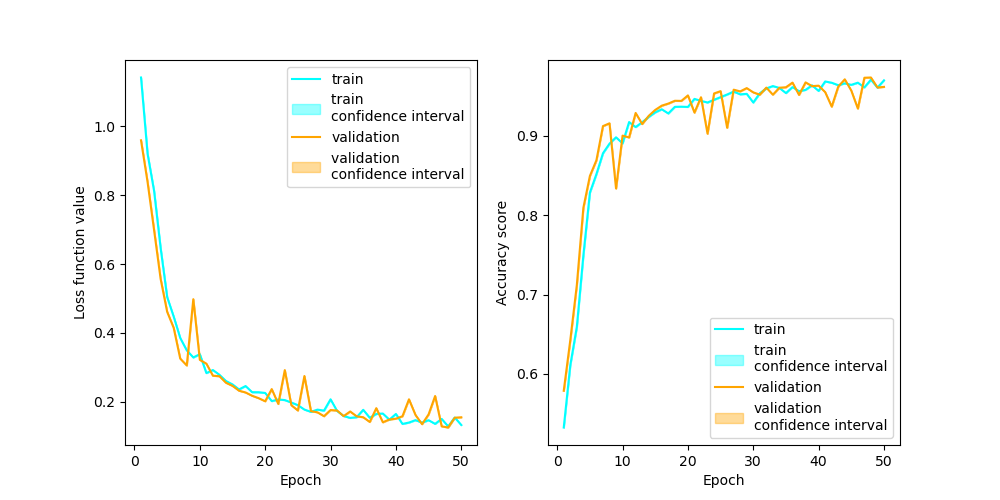

In [307]:
aux.plotTrainingHistory_avg(model_B_CAM_hist_tab, alpha=0.4)

2022-04-25 22:34:37.792874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.76      0.95      0.85      2141
           1       0.83      0.71      0.77      2138
           2       0.83      0.67      0.74      2157
           3       0.67      0.73      0.70      2121

    accuracy                           0.76      8557
   macro avg       0.77      0.76      0.76      8557
weighted avg       0.77      0.76      0.76      8557



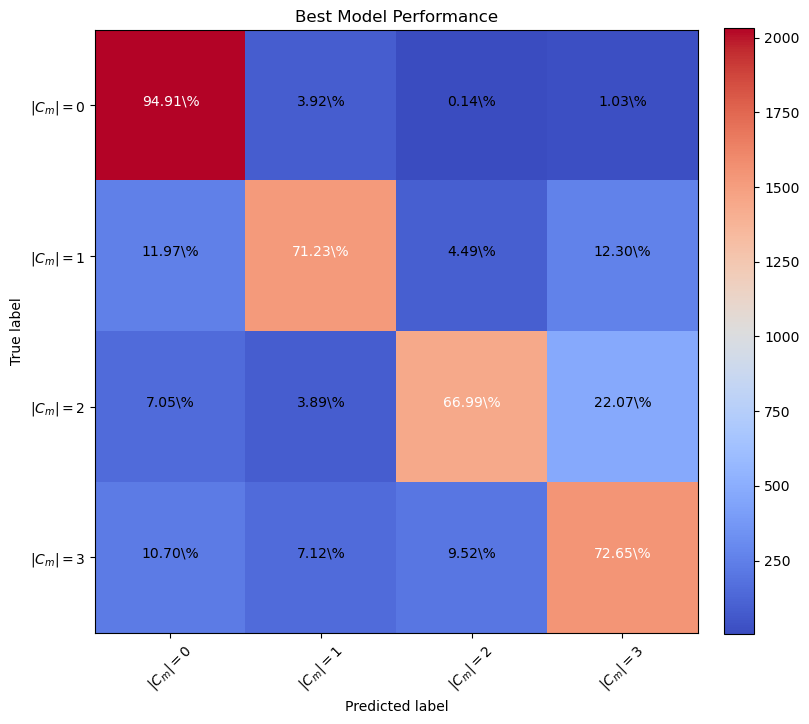

In [308]:
cm = aux.printScores(model_B_CAM, X_test,  Y_test)
display(aux.plot_confusion_matrix(cm, class_names=labels, title="Best Model Performance"))

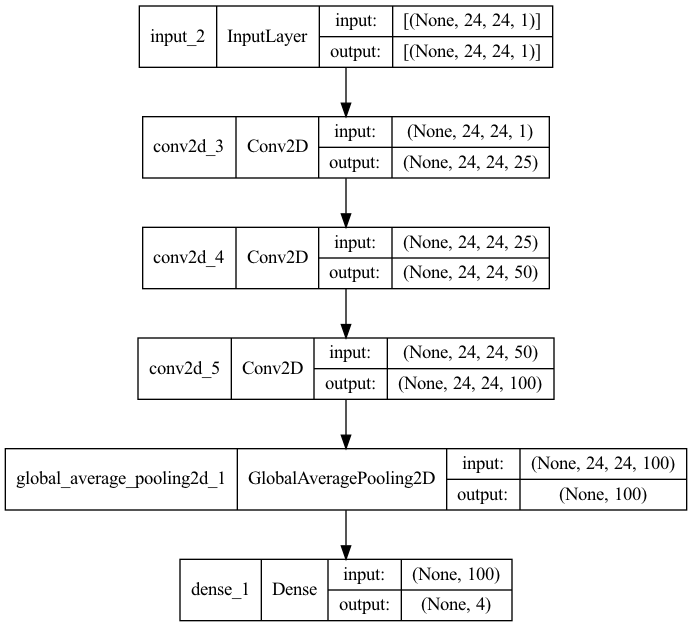

In [55]:
tf.keras.utils.plot_model(model_B_CAM, 'ML_model_B_CAM.png', show_shapes=True)

In [56]:
if save:
    # # Model B CAM
    wrpath = "Models/best_model_B_CAM.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_B_CAM, f)

    # # Model B CAM History
    wrpath = "Models/train_5_runs_model_B_CAM.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_B_CAM_tab, f)

    # # Model B CAM tab
    wrpath = "History/train_hist_5_runs_model_B_CAM.pickle"
    if os.path.isfile(wrpath):
        os.remove(wrpath)
    with open(wrpath, "wb") as f:
        pickle.dump(model_B_CAM_hist_tab, f)

Here we create a wrapper around our trained model, which now returns weights before and after GAP layer

In [313]:
class CAM:
    def __init__(self, model):
        self.model = model
        self.final_conv_name = self.get_final_conv()
        self.gap_weights = self.model.layers[-1].get_weights()[0]

    def get_final_conv(self):
        for layer in reversed(model_B_CAM.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name

    def get_CAM_dataset(self, X_test, Y_test):
        cam_model = tf.keras.Model(inputs=self.model.inputs, outputs=(self.model.get_layer(self.final_conv_name).output, self.model.layers[-1].output))
        features,results = cam_model.predict(X_test)
        classes = Y_test.numpy().argmax(axis=1)
        classes_df = pd.DataFrame(classes, columns=["Labels"])



In [314]:
cam_B = CAM(model_B_CAM)

In [315]:
# Here we look for final convolutional layer
for layer in reversed(model_B_CAM.layers):
    # check to see if the layer has a 4D output
    if len(layer.output_shape) == 4:
        final_Conv =  layer.name
        break
gap_weights = model_B_CAM.layers[-1].get_weights()[0]
cam_model = tf.keras.Model(inputs=model_B_CAM.inputs, outputs=(model_B_CAM.get_layer(final_Conv).output, model_B_CAM.layers[-1].output))

In [316]:
features,results = cam_model.predict(X_test_no_disorder)

2022-04-25 22:38:07.894160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


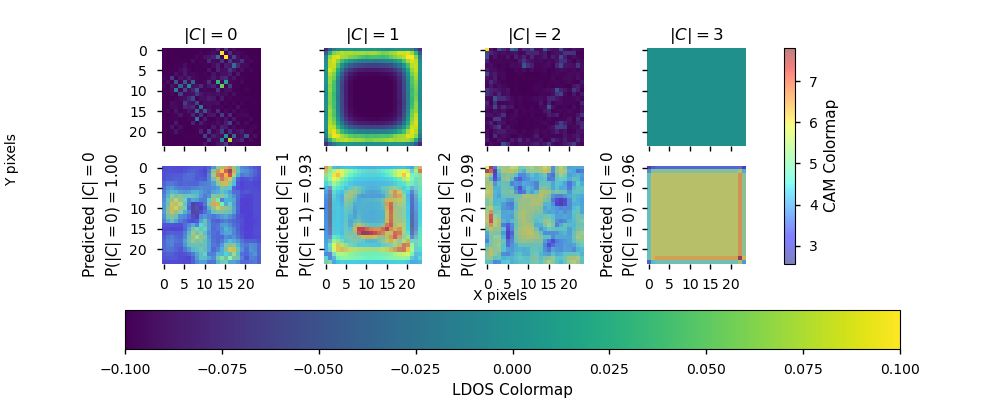

In [480]:
classes = Y_test.numpy().argmax(axis=1)
classes_df = pd.DataFrame(classes, columns=["Labels"])

fig, axs = plt.subplots(2, 4, sharey="row", figsize=(10, 4))
# plt.tight_layout()
plt.style.use("seaborn-notebook")

cmap = "viridis"

num = 11

for row in range(2):
    for idx in range(4):
        if row == 0:
            cm_loc = classes_df.loc[classes_df["Labels"] == idx].index[num]
            cm_pic = X_test[cm_loc].numpy().reshape(24,24)
            pcm = axs[row, idx].imshow(cm_pic, cmap=cmap)
            axs[row, idx].set_title(f"$|C| = {idx}$")
        else:
            cm_loc = classes_df.loc[classes_df["Labels"] == idx].index[num]
            features_for_one_img = features[cm_loc,:,:,:]
            height_roomout = X_test.shape[1]/features_for_one_img.shape[0]
            width_roomout  = X_test.shape[2]/features_for_one_img.shape[1]
            cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
            pred = np.argmax(results[cm_loc])
            cam_weights = gap_weights[:,pred]
            cam_output  = np.dot(cam_features,cam_weights)
            buf = f'Predicted $|C| = ${pred}\nP$(|C| = {pred}) = {results[cm_loc][pred]:.2f}$'
            axs[row, idx].imshow(np.squeeze(X_test[cm_loc],-1), alpha=0.5)
            axs[row, idx].set_ylabel(buf, loc="center", rotation='vertical')
            cam_cmap = axs[row, idx].imshow(cam_output, cmap='jet', alpha=0.5)


fig.text(0.5, 0.25, "X pixels", ha="center")
fig.text(0.005, 0.6, "Y pixels", va="center", rotation="vertical")
fig.colorbar(pcm, ax=[axs], location="bottom", label="LDOS Colormap")
fig.colorbar(cam_cmap, ax=[axs], location="right", label="CAM Colormap")

for ax in axs.flat:
    ax.set(frame_on=False, xticks=np.arange(0, 24, 5), yticks=np.arange(0, 24, 5))

for ax in axs[0,:]:
    ax.label_outer()

## Grad-CAM

In [309]:
grad_cam_model = model_B_CAM

In [318]:
gap_weights = grad_cam_model.layers[-1].get_weights()[0]
cam_model = tf.keras.Model(inputs=grad_cam_model.inputs, outputs=(grad_cam_model.get_layer(final_Conv).output, grad_cam_model.output))

In [160]:
def make_gradcam_heatmap(input_img, model, pred_index=None):
    # Here we look for the final convolutional layer
    for layer in reversed(model.layers):
        # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
            last_conv_layer_name =  layer.name
            break

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(input_img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), pred_index, preds

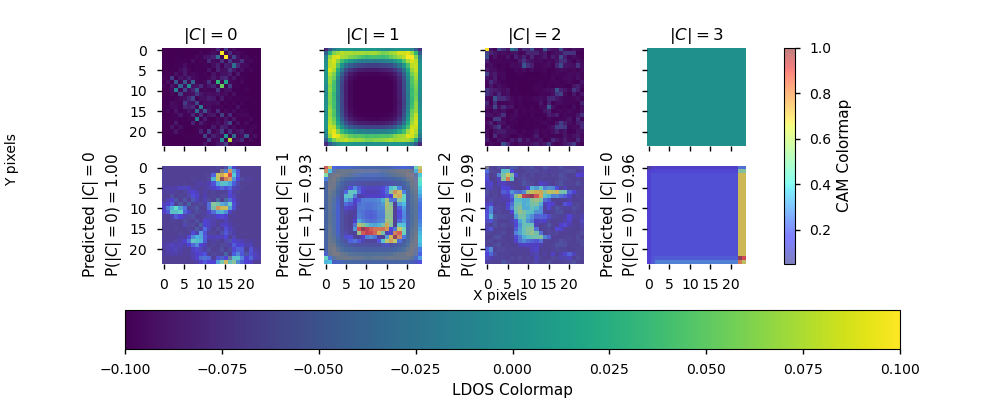

In [322]:
classes = Y_test.numpy().argmax(axis=1)
classes_df = pd.DataFrame(classes, columns=["Labels"])

fig, axs = plt.subplots(2, 4, sharey="row", figsize=(10, 4))
# plt.tight_layout()
plt.style.use("seaborn-notebook")

cmap = "viridis"

num = 11

for row in range(2):
    for idx in range(4):
        if row == 0:
            cm_loc = classes_df.loc[classes_df["Labels"] == idx].index[num]
            cm_pic = X_test[cm_loc].numpy().reshape(24,24)
            pcm = axs[row, idx].imshow(cm_pic, cmap=cmap)
            axs[row, idx].set_title(f"$|C| = {idx}$")
        else:
            cm_loc = classes_df.loc[classes_df["Labels"] == idx].index[num]
            img = X_test[cm_loc]
            img_exp = np.expand_dims(img, axis=0)
            heatmap, pred, preds = make_gradcam_heatmap(img_exp, grad_cam_model)
            buf = f'Predicted $|C| = ${pred}\nP$(|C| = {pred}) = {np.max(preds):.2f}$'
            axs[row, idx].imshow(np.squeeze(img,-1), alpha=0.5)
            axs[row, idx].set_ylabel(buf, loc="center", rotation='vertical')
            cam_cmap = axs[row, idx].imshow(heatmap, cmap='jet',alpha=0.5)


fig.text(0.5, 0.25, "X pixels", ha="center")
fig.text(0.005, 0.6, "Y pixels", va="center", rotation="vertical")
fig.colorbar(pcm, ax=[axs], location="bottom", label="LDOS Colormap")
fig.colorbar(cam_cmap, ax=[axs], location="right", label="CAM Colormap")

for ax in axs.flat:
    ax.set(frame_on=False, xticks=np.arange(0, 24, 5), yticks=np.arange(0, 24, 5))
    ax.grid(False)

for ax in axs[0,:]:
    ax.label_outer()

# Code linting

In [ ]:
!black Raw_Data

In [ ]:
!black auxiliary_funcs.py

In [ ]:
print("Elapsed time\n--- %s seconds ---" % (time.time() - start_time))